In [1]:
import pandas as pd
import numpy as np
import datetime
from scorepi import *
from epiweeks import Week
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import matplotlib as mpl
import random
from datetime import timedelta
from numba import njit

import warnings
warnings.filterwarnings('ignore')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [20]:
import matplotlib.dates as mdates
def set_date_axis_fmt(ax):
    # Set the locator
    locator = mdates.MonthLocator()  # every month
    # Specify the format
    fmt = mdates.DateFormatter('%b %Y')

    X = ax.xaxis
    X.set_major_locator(locator)
    # Specify formatter
    X.set_major_formatter(fmt)
 

In [3]:
# download surveillance data

incidence = True
target_obs = 'hospitalization'
observations = pd.read_parquet(f"../fludat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")
observations['date'] = pd.to_datetime(observations['date'])
observations = observations.drop(columns=['Unnamed: 0', 'weekly_rate'])

start_week = pd.to_datetime('2023-08-12')
max_date = pd.to_datetime(observations.date.max())
observations = observations[(observations['date'] >= start_week) & \
                                (observations['date'] <= max_date)]

   
#aggregate to weekly
observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()

#transform to Observation object
observations = Observations(observations)


In [4]:
obs = observations[observations.location=='US']

# Baseline Model

In [4]:
class QuantileBaseline:
    def __init__(self, inc_diffs, symmetrize=True):
        self.inc_diffs = inc_diffs
        self.symmetrize = symmetrize
      
    
def fit_quantile_baseline(incidence,target, symmetrize=True, window_size=None):
    if window_size is None:
        window_size = len(incidence) - 1
    if window_size >= len(incidence):
        window_size = len(incidence) - 1

    diffs = np.diff(incidence['value'])[-window_size:]
    diffs = diffs[~np.isnan(diffs)]
    
    if symmetrize:
        inc_diffs = list(diffs) + [-x for x in diffs]
    else:
        inc_diffs = list(diffs)

    return QuantileBaseline(inc_diffs=np.array(inc_diffs), symmetrize=symmetrize)



In [6]:
# generate baseline model

quantiles = [0.01, 0.025] + list(np.arange(0.05, 0.96, 0.05)) + [0.975, 0.99]
horizon = 4
num_samples = 100000

symmetrize=True
incidence = True
target_obs = 'hospitalization'
observations = pd.read_parquet(f"../fludat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")
observations['date'] = pd.to_datetime(observations['date'])
observations = observations.drop(columns=['Unnamed: 0', 'weekly_rate'])

start_week = pd.to_datetime('2023-08-12')
max_date = pd.to_datetime(observations.date.max())

observations = observations[(observations['date'] <= max_date) & (observations['date'] >= pd.to_datetime('2022-09-01'))]

   
#aggregate to weekly
observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()

#transform to Observation object
observations = Observations(observations)


target = 'inc hosp'
# Generate forecast week end dates
forecast_week_end_dates = [num for num in observations['date'].unique() if num >= pd.to_datetime('2023-08-12')]

results_list = []

baseline_model = pd.DataFrame()
for forecast_week_end_date in forecast_week_end_dates:
    data = observations.copy()
    
    if len(data)==0:
        continue
    
    unique_locations = data['location'].unique()
    
    for location in unique_locations:
    
        location_data = data[data['location'] == location]
        
        location_data = location_data[location_data['date'] <= forecast_week_end_date]
        
        baseline_fit = fit_quantile_baseline(incidence=location_data,target=target, symmetrize=True, 
                                             window_size=None)


        ########### Predict function #############
        inc_data = location_data['value']

        last_observed_value = inc_data.iloc[-1]
        
        # Compute quantiles
        
        sampled_inc_diffs = np.quantile(baseline_fit.inc_diffs, np.linspace(0, 1, num_samples))

        # Ensure the median difference is 0
        median_diff = np.median(sampled_inc_diffs)
        sampled_inc_diffs -= median_diff

        # Compute the raw sampled incidence values
        sampled_inc_raw = last_observed_value + sampled_inc_diffs

        # Enforce non-negative incidence
        sampled_inc_raw = np.maximum(sampled_inc_raw, 0)
        predictions = np.quantile(sampled_inc_raw, quantiles, axis=0)
        
        #save first horizon
        results = pd.DataFrame({'horizon':1, 'forecast_date':pd.to_datetime(forecast_week_end_date),
                                'target_end_date': pd.to_datetime(forecast_week_end_date) + timedelta(weeks=1)  ,
                                'target':'inc hosp','location':location ,'quantile':quantiles, 'value':predictions})
        
        baseline_model = pd.concat([baseline_model, results])
        
        for h in list(range(2, horizon+1)):
            
            # Sample differences again for new horizon
            sampled_inc_diffs = np.random.choice(sampled_inc_diffs, size=num_samples, replace=True)
            sampled_inc_raw = sampled_inc_raw + sampled_inc_diffs

            # Adjust incidence if symmetrize is TRUE
            if symmetrize:
                sampled_inc_corrected = sampled_inc_raw - (np.median(sampled_inc_raw) - last_observed_value)
            else:
                sampled_inc_corrected = sampled_inc_raw

            # Ensure non-negative incidence
            sampled_inc_corrected = np.maximum(sampled_inc_corrected, 0)

            
            
            predictionshorizon = np.quantile(sampled_inc_corrected, quantiles, axis=0)
        
            resultshorizon = pd.DataFrame({'horizon':h, 'forecast_date':pd.to_datetime(forecast_week_end_date),
                                           'target_end_date':pd.to_datetime(forecast_week_end_date) + timedelta(weeks=1*h),
                                           'target':'inc hosp','location':location , 'quantile':quantiles, 
                                    'value':predictionshorizon})
        
            baseline_model = pd.concat([baseline_model, resultshorizon])
        
        
        
baseline_model['quantile'] = baseline_model['quantile'].round(2)         
        
        
        


In [ ]:
baseline_model.to_pickle('../fludat/baseline_model_flu23-24.pkl')

In [ ]:
df

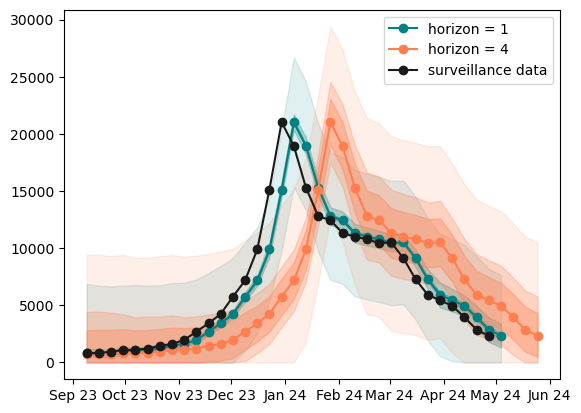

In [7]:
# plot 1 and 4-week-ahead baseline model forecasts for the 2023-24 flu season

quants = [(0.02,0.98),(.15, .85),(0.25,0.75)]
map_alpha = lambda interval_range: 0.5 * (1-interval_range) + 0.1

fig, ax = plt.subplots(1,1)

observations = pd.read_parquet(f"../fludat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")
observations['date'] = pd.to_datetime(observations['date'])
observations = observations.drop(columns=['Unnamed: 0', 'weekly_rate'])

start_week = pd.to_datetime('2023-09-09')
max_date = pd.to_datetime(observations.date.max())

observations = observations[(observations['date'] <= max_date) & (observations['date'] >= pd.to_datetime('2022-09-01'))]

   
#aggregate to weekly
observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()

#transform to Observation object
observations = Observations(observations)


#horizon = 1
colors = ['teal', 'coral']
location='US'
i=0
for horizon in [1,4]:
    for q in quants:
        
        alpha = map_alpha(q[1] - q[0])
        df = baseline_model[ (baseline_model.horizon==horizon)&\
                          (baseline_model.location == location) & (baseline_model.target_end_date>=start_week)]

        qupp = baseline_model[(baseline_model['quantile']==q[0]) & (baseline_model.horizon==horizon)&\
                          (baseline_model.location == location)&(baseline_model.target_end_date>=start_week)].value
        qlow = baseline_model[(baseline_model['quantile']==q[1]) & (baseline_model.horizon==horizon) &\
                          (baseline_model.location == location)&(baseline_model.target_end_date>=start_week)].value

        plt.fill_between(df.target_end_date.unique(),qupp,qlow, color=colors[i], alpha=alpha)

    qmed = baseline_model[(baseline_model['quantile']==0.5) & (baseline_model.horizon==horizon) &\
                          (baseline_model.location == location)&(baseline_model.target_end_date>=start_week)].value

    plt.plot(df.target_end_date.unique(),qmed,'-o', color=colors[i], alpha=1, label='horizon = '+ str(horizon))
    
    i+=1

set_date_axis_fmt(ax)
    
observations['date'] = pd.to_datetime(observations['date'])
observations = observations[(observations.location==location) & (observations.date>=pd.to_datetime('2023-09-09')) ]


plt.plot(observations.date,observations.value, '-o', color='#1a1a1a', label = 'surveillance data')
   
plt.legend()

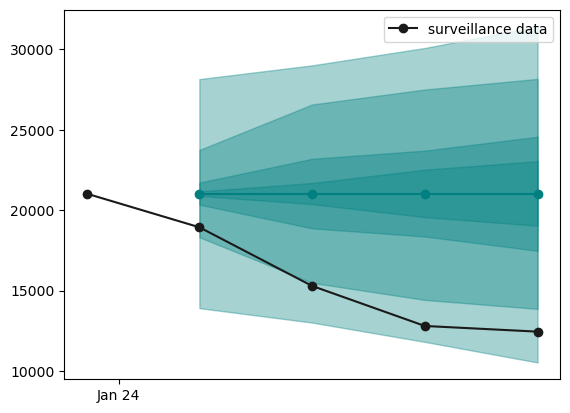

In [8]:
# 1-4 week ahead forecasts made at a given forecast date
baseline_model = pd.read_pickle('../fludat/baseline_model_flu23-24.pkl')
quants = [(0.01,0.99),(0.05,0.95),(.15, .85),(0.25,0.75)]
map_alpha = lambda interval_range: 0.5 * (1-interval_range) + 0.1

fig, ax = plt.subplots(1,1)

#horizon = 1
colors = ['teal', 'coral']
location='US'
i=0

for q in quants:
    df = baseline_model[ (baseline_model.forecast_date==pd.to_datetime('2023-12-30'))&\
                      (baseline_model.location == location)]

    qupp = baseline_model[(baseline_model['quantile']==q[0]) & (baseline_model.forecast_date==pd.to_datetime('2023-12-30'))&\
                      (baseline_model.location == location)].value
    qlow = baseline_model[(baseline_model['quantile']==q[1]) & (baseline_model.forecast_date==pd.to_datetime('2023-12-30')) &\
                      (baseline_model.location == location)].value

    plt.fill_between(df.target_end_date.unique(),qupp,qlow, color=colors[i], alpha=alpha)

qmed = baseline_model[(baseline_model['quantile']==0.5) & (baseline_model.forecast_date==pd.to_datetime('2023-12-30')) &\
                      (baseline_model.location == location)].value

plt.plot(df.target_end_date.unique(),qmed,'-o', color=colors[i], alpha=1)

i+=1

set_date_axis_fmt(ax)
    
observations = observations[(observations.location==location) ]
observations['date'] = pd.to_datetime(observations['date'])
observations = observations[(observations.date>=pd.to_datetime('2023-12-30'))&\
                            (observations.date<=pd.to_datetime('2024-01-27'))]

plt.plot(observations.date,observations.value, '-o', color='#1a1a1a', label = 'surveillance data')
   
plt.legend()

# Generate trajectories for baseline model

In [9]:
# generate trajectories by sampling from the distribution of historical differences

quantiles = [0.01, 0.025] + list(np.arange(0.05, 0.96, 0.05)) + [0.975, 0.99]
horizon = 4
num_samples = 100


incidence = True
symmetrize = True
target_obs = 'hospitalization'
observations = pd.read_parquet(f"../fludat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")
observations['date'] = pd.to_datetime(observations['date'])
observations = observations.drop(columns=['Unnamed: 0', 'weekly_rate'])

start_week = pd.to_datetime('2023-08-12')
max_date = pd.to_datetime(observations.date.max())

observations = observations[(observations['date'] <= max_date) & (observations['date'] >= pd.to_datetime('2022-09-01'))]

   
#aggregate to weekly
observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()

#transform to Observation object
observations = Observations(observations)


target = 'inc hosp'
# Generate forecast week end dates
forecast_week_end_dates = [num for num in observations['date'].unique() if num >= pd.to_datetime('2023-08-12')]

results_list = []

baseline_model = pd.DataFrame()

for forecast_week_end_date in forecast_week_end_dates:
    data = observations.copy()
    
    if len(data)==0:
        continue
    
    unique_locations = data['location'].unique()
    
    for location in unique_locations:
    
        location_data = data[data['location'] == location]
        
        location_data = location_data[location_data['date'] <= forecast_week_end_date]
        
        baseline_fit = fit_quantile_baseline(incidence=location_data,target=target, symmetrize=True, 
                                             window_size=None)


        ########### Predict function #############
        inc_data = location_data['value']

        last_observed_value = inc_data.iloc[-1]
    
        # Compute quantiles
        
        sampled_inc_diffs = np.quantile(baseline_fit.inc_diffs, np.linspace(0, 1, num_samples))

        # Ensure the median difference is 0
        median_diff = np.median(sampled_inc_diffs)
        sampled_inc_diffs -= median_diff

        # Compute the raw sampled incidence values
        sampled_inc_raw = last_observed_value + sampled_inc_diffs

        # Enforce non-negative incidence
        sampled_inc_raw = np.maximum(sampled_inc_raw, 0)
 
        #save first horizon
        results = pd.DataFrame({'horizon':1, 'forecast_date':pd.to_datetime(forecast_week_end_date),
                                'target_end_date': pd.to_datetime(forecast_week_end_date) + timedelta(weeks=1)  ,
                                'target':'inc hosp','location':location ,'trajectory_id':list(range(100)), 
                                'value':sampled_inc_raw})
        
        baseline_model = pd.concat([baseline_model, results])
        
        for h in list(range(2, horizon+1)):
            
            # Sample differences again for new horizon
            sampled_inc_diffs = np.random.choice(sampled_inc_diffs, size=num_samples, replace=True)
            sampled_inc_raw = sampled_inc_raw + sampled_inc_diffs

            # Adjust incidence if symmetrize is TRUE
            if symmetrize:
                sampled_inc_corrected = sampled_inc_raw - (np.median(sampled_inc_raw) - last_observed_value)
            else:
                sampled_inc_corrected = sampled_inc_raw

            # Ensure non-negative incidence
            sampled_inc_corrected = np.maximum(sampled_inc_corrected, 0)

            resultshorizon = pd.DataFrame({'horizon':h, 'forecast_date':pd.to_datetime(forecast_week_end_date),
                                           'target_end_date':pd.to_datetime(forecast_week_end_date) + timedelta(weeks=1*h),
                                           'target':'inc hosp','location':location , 'trajectory_id':list(range(100)), 
                                    'value':sampled_inc_corrected})
        
            baseline_model = pd.concat([baseline_model, resultshorizon])
               


In [10]:
baseline_model[baseline_model.horizon==4]

,horizon,forecast_date,target_end_date,target,location,trajectory_id,value
0,4,2023-08-12,2023-09-09,inc hosp,01,0,0.000000
1,4,2023-08-12,2023-09-09,inc hosp,01,1,0.000000
2,4,2023-08-12,2023-09-09,inc hosp,01,2,0.000000
3,4,2023-08-12,2023-09-09,inc hosp,01,3,0.000000
4,4,2023-08-12,2023-09-09,inc hosp,01,4,6.151515
...,...,...,...,...,...,...,...
95,4,2024-04-27,2024-05-25,inc hosp,34,95,308.590909
96,4,2024-04-27,2024-05-25,inc hosp,34,96,275.954545
97,4,2024-04-27,2024-05-25,inc hosp,34,97,239.045455
98,4,2024-04-27,2024-05-25,inc hosp,34,98,432.681818


In [ ]:
baseline_model.to_pickle('../fludat/flu-baseline_trajectories.pkl')

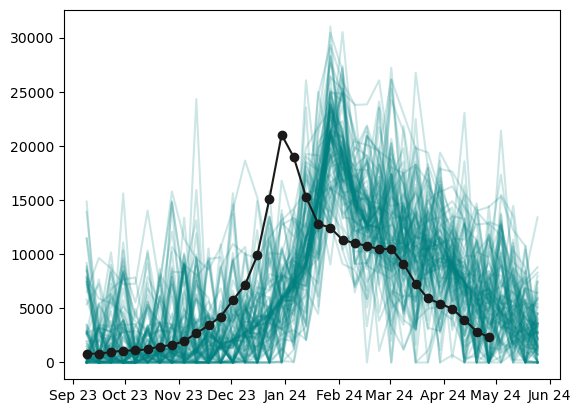

In [5]:
# plot baseline model trajectories
baseline_model = pd.read_pickle('../fludat/flu-baseline_trajectories.pkl')
observations = pd.read_parquet(f"../fludat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")
observations['date'] = pd.to_datetime(observations['date'])
observations = observations.drop(columns=['Unnamed: 0', 'weekly_rate'])

start_week = pd.to_datetime('2023-08-12')
max_date = pd.to_datetime(observations.date.max())

observations = observations[(observations['date'] <= max_date) & (observations['date'] >= pd.to_datetime('2022-09-09'))]

   
#aggregate to weekly
observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()

#transform to Observation object
observations = Observations(observations)

fig,ax = plt.subplots(1,1)

df = baseline_model[(baseline_model.location=='US') & (baseline_model.horizon==4)]
for i in df.trajectory_id.unique():
    plt.plot(df.target_end_date.unique(), df[df.trajectory_id==i].value, color='teal', alpha=.2)
    
observations['date'] = pd.to_datetime(observations['date'])
observations = observations[(observations.location=='US') & (observations.date>=pd.to_datetime('2023-09-09')) ]


plt.plot(observations.date,observations.value, '-o', color='#1a1a1a', label = 'surveillance data')

set_date_axis_fmt(ax)

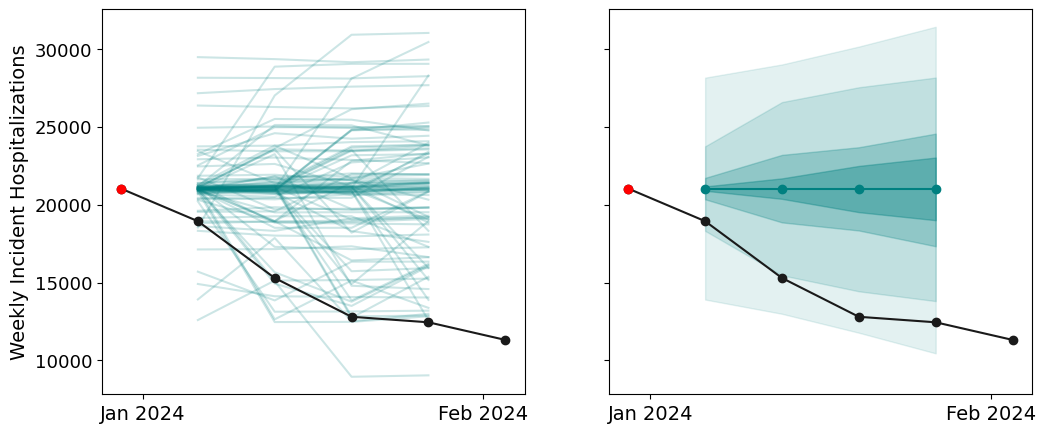

In [43]:
# plot baseline model trajectories
baseline_model = pd.read_pickle('../fludat/flu-baseline_trajectories.pkl')
observations = pd.read_parquet(f"../fludat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")
observations['date'] = pd.to_datetime(observations['date'])
observations = observations.drop(columns=['Unnamed: 0', 'weekly_rate'])

start_week = pd.to_datetime('2023-08-12')
max_date = pd.to_datetime(observations.date.max())

observations = observations[(observations['date'] <= max_date) & (observations['date'] >= pd.to_datetime('2022-09-09'))]

   
#aggregate to weekly
observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()

#transform to Observation object
observations = Observations(observations)

fig,ax = plt.subplots(1,2,figsize=(12,5),sharey=True)

plt.subplot(1,2,1)
#df = baseline_model[(baseline_model.location=='US') & (baseline_model.horizon==4)]
df = baseline_model[(baseline_model.location=='US') & (baseline_model.forecast_date==pd.to_datetime('2023-12-30'))]
for i in df.trajectory_id.unique():
    if i==0:
        plt.plot(df.target_end_date.unique(), df[df.trajectory_id==i].value, color='teal', alpha=.2,label=\
                'Baseline Forecast Model')
    else:
        plt.plot(df.target_end_date.unique(), df[df.trajectory_id==i].value, color='teal', alpha=.2)
    
    
    
observations['date'] = pd.to_datetime(observations['date'])
observations = observations[(observations.location=='US') & (observations.date>=pd.to_datetime('2023-09-09')) ]
observations = observations[(observations.date>=pd.to_datetime('2023-12-30'))&\
                            (observations.date<=pd.to_datetime('2024-02-07'))]


plt.plot(observations.date,observations.value, '-o', color='#1a1a1a', label = 'Observed Data')

obs = observations[observations.date==observations.date.min()]
plt.plot(obs.date,obs.value, '-o', color='red', label = 'Most Recently Observed Data')

set_date_axis_fmt(ax[0])
plt.xticks(fontsize=14)
plt.yticks(fontsize=13)

plt.ylabel('Weekly Incident Hospitalizations', fontsize=14)
#plt.legend()


plt.subplot(1,2,2)

baseline_model = pd.read_pickle('../fludat/baseline_model_flu23-24.pkl')
quants = [(0.01,0.99),(0.05,0.95),(.15, .85),(0.25,0.75)]
map_alpha = lambda interval_range: 0.5 * (1-interval_range) + 0.1

#horizon = 1
colors = ['teal', 'coral']
location='US'
i=0

for q in quants:
    alpha = map_alpha(q[1] - q[0])
    
    df = baseline_model[ (baseline_model.forecast_date==pd.to_datetime('2023-12-30'))&\
                      (baseline_model.location == location)]

    qupp = baseline_model[(baseline_model['quantile']==q[0]) & (baseline_model.forecast_date==pd.to_datetime('2023-12-30'))&\
                      (baseline_model.location == location)].value
    qlow = baseline_model[(baseline_model['quantile']==q[1]) & (baseline_model.forecast_date==pd.to_datetime('2023-12-30')) &\
                      (baseline_model.location == location)].value

    plt.fill_between(df.target_end_date.unique(),qupp,qlow, color=colors[i], alpha=alpha)

qmed = baseline_model[(baseline_model['quantile']==0.5) & (baseline_model.forecast_date==pd.to_datetime('2023-12-30')) &\
                      (baseline_model.location == location)].value

plt.plot(df.target_end_date.unique(),qmed,'-o', color=colors[i], alpha=1,label='Baseline Forecast Model')

i+=1

set_date_axis_fmt(ax[1])
    
observations = observations[(observations.location==location) ]
observations['date'] = pd.to_datetime(observations['date'])
observations = observations[(observations.date>=pd.to_datetime('2023-12-30'))&\
                            (observations.date<=pd.to_datetime('2024-02-07'))]

plt.plot(observations.date,observations.value, '-o', color='#1a1a1a', label = 'Observed Data')


obs = observations[observations.date==observations.date.min()]
plt.plot(obs.date,obs.value, '-o', color='red', label = 'Most Recently Observed Data')
   
plt.xticks(fontsize=14)
plt.yticks(fontsize=13)

#plt.legend()

plt.savefig('../figs/baseline_model_fig.pdf')

In [6]:
baseline_model

,horizon,forecast_date,target_end_date,target,location,trajectory_id,value
0,1,2023-08-12,2023-08-19,inc hosp,01,0,0.000000
1,1,2023-08-12,2023-08-19,inc hosp,01,1,0.000000
2,1,2023-08-12,2023-08-19,inc hosp,01,2,0.000000
3,1,2023-08-12,2023-08-19,inc hosp,01,3,0.000000
4,1,2023-08-12,2023-08-19,inc hosp,01,4,0.000000
...,...,...,...,...,...,...,...
95,4,2024-04-27,2024-05-25,inc hosp,34,95,0.000000
96,4,2024-04-27,2024-05-25,inc hosp,34,96,135.363636
97,4,2024-04-27,2024-05-25,inc hosp,34,97,297.909091
98,4,2024-04-27,2024-05-25,inc hosp,34,98,325.363636


# Energy score of baseline model

In [ ]:
# calculate energy score for flu baseline model from trajectories

from numba import njit
@njit
def energyscore(X,y):
    # X is matrix of trajectories, y is observations
    ES = 0
    N = X.shape[0]
    for i in range(N):
        ES += np.sqrt(np.sum((X[i]-y)**2))/N
    for i in range(N):
        for j in range(N):
            ES -= np.sqrt(np.sum((X[i]-X[j])**2))/(2*N**2)
    return ES

baseline_model= pd.read_pickle('../fludat/flu-baseline_trajectories.pkl')
baselinedf = baseline_model[baseline_model.horizon==4]

energyscoresdf = pd.DataFrame()

for location in baselinedf.location.unique():
    
    observations = pd.read_parquet(f"../fludat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")
    observations['date'] = pd.to_datetime(observations['date'])

    dffilt = baselinedf[(baselinedf.location==location) & (baselinedf.target_end_date>=pd.to_datetime('2023-09-09'))&\
                       (baselinedf.target_end_date<=observations.date.max())]
    
    
    if len(dffilt) == 0:
        print(f'no predictions  at location {loc} ')
        continue

    # format and filter observed data
    observations = observations[(observations['date'] >= dffilt.target_end_date.min()) & \
                                (observations['date'] <= dffilt.target_end_date.max())]   

    #aggregate to weekly
    observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()

    #transform to Observation object
    observations = Observations(observations)

    #filter location
    observations = observations[observations['location'] == location]

    dffilt = dffilt[dffilt.target_end_date <= observations.date.max()]

    
    # calculate energy score
    y = np.array(observations.value)
    X = [np.array(dffilt[dffilt['trajectory_id'] == i].value) for i in dffilt['trajectory_id'].unique()]

    ES = energyscore(np.array(X),y)


    # save results
    newrow = pd.DataFrame({'Model':'flu-baseline','location':location, 
                        'target':'inc hosp', 'horizon':4, 'energyscore':ES, }, index=[0])

    energyscoresdf = pd.concat([energyscoresdf, newrow])


energyscoresdf = energyscoresdf.reset_index()
energyscoresdf = energyscoresdf.drop(columns=['index'])   




In [ ]:
energyscoresdf

In [ ]:
energyscoresdf.to_pickle('../fludat/flu-baseline_energyscore_118.pkl')

# Multi-dimensional energy score of baseline model

In [12]:
from numba import njit
@njit
def energyscore_multipletargets(X,y):
    # X is matrix of trajectories, y is observations
    ES = 0
    N = X.shape[0]
    for i in range(N):
        ES += np.sqrt(np.sum(((X[i]-y)**2)/(np.sum(y,axis=1)[:, np.newaxis])**2))/ N
    for i in range(N):
        for j in range(N):
            ES -= np.sqrt(np.sum(((X[i]-X[j])**2)/(np.sum(y,axis=1)[:, np.newaxis])**2))/(2*N**2)
    return ES


In [14]:
# calculate multi-dimensional score for baseline model

energyscores_locations = pd.DataFrame()

baselinedf = baseline_model[baseline_model.horizon==4]

# get surveillance data
target = 'hospitalization'
incidence=True
hosp = pd.read_parquet(f"../fludat/truth_{'inc' if incidence else 'cum'}_{target}.pq")
hosp['date'] = pd.to_datetime(hosp['date'])
hosp = hosp[(hosp.date>=pd.to_datetime('2023-09-09'))].sort_values(by=['date']).reset_index().drop(columns=\
                                                                        ['Unnamed: 0', 'index','weekly_rate'])
hosp = hosp[(hosp.location != '72') &(hosp.location!='66') ]


obs = np.array([np.array(hosp[hosp.location == i].value) for \
                     i in hosp.location.unique()])
locations = list(hosp.location.unique())

energyscores_locations = pd.DataFrame()
for it in range(50):
    
    dfall = pd.DataFrame()
    j=0
    
    # create trajectory matrices
    for loc in locations:
        if loc in ['72', '66']:
            continue
        predictionshosp = baselinedf[(baselinedf.target_end_date <= hosp.date.max()) & \
                                    (baselinedf.target_end_date >= hosp.date.min())&\
                                    (baselinedf.location==loc)]
        newid = random.sample(list(predictionshosp['trajectory_id'].unique()), 
                              k=len(list(predictionshosp['trajectory_id'].unique())))
        predictionshosp['new_id'] = predictionshosp['trajectory_id'].apply(lambda key: newid[key-1])

        dfall = pd.concat([dfall,predictionshosp])

    tlist = []
    for tid in dfall.new_id.unique():
        dfilt = dfall[dfall.new_id==tid]
        llist = []
        for loc in dfilt.location.unique():
            d = dfilt[dfilt.location==loc].sort_values(by='target_end_date')
            llist.append(list(d.value))

        tlist.append(llist)


    A = np.array(tlist)

    # calculate multi-dimensional energy score
    ES = energyscore_multipletargets(A,obs)


    # save results
    newrow = pd.DataFrame({'Model':'baseline' , 'location':'US',  
                         'energyscore': ES, 'it':it}, index=[0])

    energyscores_locations = pd.concat([energyscores_locations, newrow])

energyscores_locations = energyscores_locations.reset_index().drop(columns=['index'])  

In [15]:
energyscores_locations

,Model,location,energyscore,it
0,baseline,US,0.812756,0
1,baseline,US,0.812691,1
2,baseline,US,0.812668,2
3,baseline,US,0.812689,3
4,baseline,US,0.812860,4
5,baseline,US,0.812766,5
6,baseline,US,0.812789,6
7,baseline,US,0.812743,7
8,baseline,US,0.812840,8
9,baseline,US,0.812853,9


In [16]:
energyscores_locations.to_csv('../fludat/multitarget_loc_baseline_1204.csv')

# Multi-dimensional score without normalization factor

In [4]:
from numba import njit
@njit
def energyscore_multipletargets_no_norm(X,y):
    # X is matrix of trajectories, y is observations
    ES = 0
    N = X.shape[0]
    for i in range(N):
        ES += np.sqrt(np.sum((X[i]-y)**2))/ N
    for i in range(N):
        for j in range(N):
            ES -= np.sqrt(np.sum((X[i]-X[j])**2))/(2*N**2)
    return ES


In [6]:
# calculate multi-dimensional score for baseline model

energyscores_locations = pd.DataFrame()

baseline_model= pd.read_pickle('../fludat/flu-baseline_trajectories.pkl')
baselinedf = baseline_model[baseline_model.horizon==4]

# get surveillance data
target = 'hospitalization'
incidence=True
hosp = pd.read_parquet(f"../fludat/truth_{'inc' if incidence else 'cum'}_{target}.pq")
hosp['date'] = pd.to_datetime(hosp['date'])
hosp = hosp[(hosp.date>=pd.to_datetime('2023-09-09'))].sort_values(by=['date']).reset_index().drop(columns=\
                                                                        ['Unnamed: 0', 'index','weekly_rate'])
hosp = hosp[(hosp.location != '72') &(hosp.location!='66') ]


obs = np.array([np.array(hosp[hosp.location == i].value) for \
                     i in hosp.location.unique()])
locations = list(hosp.location.unique())

energyscores_locations = pd.DataFrame()
for it in range(50):
    
    dfall = pd.DataFrame()
    j=0
    
    # create trajectory matrices
    for loc in locations:
        if loc in ['72', '66']:
            continue
        predictionshosp = baselinedf[(baselinedf.target_end_date <= hosp.date.max()) & \
                                    (baselinedf.target_end_date >= hosp.date.min())&\
                                    (baselinedf.location==loc)]
        newid = random.sample(list(predictionshosp['trajectory_id'].unique()), 
                              k=len(list(predictionshosp['trajectory_id'].unique())))
        predictionshosp['new_id'] = predictionshosp['trajectory_id'].apply(lambda key: newid[key-1])

        dfall = pd.concat([dfall,predictionshosp])

    tlist = []
    for tid in dfall.new_id.unique():
        dfilt = dfall[dfall.new_id==tid]
        llist = []
        for loc in dfilt.location.unique():
            d = dfilt[dfilt.location==loc].sort_values(by='target_end_date')
            llist.append(list(d.value))

        tlist.append(llist)


    A = np.array(tlist)

    # calculate multi-dimensional energy score
    ES = energyscore_multipletargets_no_norm(A,obs)


    # save results
    newrow = pd.DataFrame({'Model':'baseline' , 'location':'US',  
                         'energyscore': ES, 'it':it}, index=[0])

    energyscores_locations = pd.concat([energyscores_locations, newrow])

energyscores_locations = energyscores_locations.reset_index().drop(columns=['index'])  

In [8]:
energyscores_locations.to_csv('../fludat/multitarget_loc_baseline_no_norm.csv')